In [36]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
%reset -f

In [37]:
import numpy as np
import os
import pandas as pd
import random
import matplotlib.pyplot as plt
from scipy.io import loadmat
from math import sqrt
# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from random import sample 

## Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score

## 1.Load and Split Dataset

In [38]:
# Regression
## 300 records from Northridge with dt=0.005 and T=30
NR_data=pd.read_csv('Result_NR_300.csv',header=None)
NR_data.columns = ['Weight','Height','K1','Q','K2','T','Q/W','Drift']
NR_data.index = range(len(NR_data))
NR_data.head()

,Weight,Height,K1,Q,K2,T,Q/W,Drift
0,2210000.0,7.148,25600000.0,1090000.0,1700000.0,0.58684,0.493,0.015880
1,2210000.0,7.148,25600000.0,1090000.0,1700000.0,0.58684,0.493,0.004240
2,2210000.0,7.148,25600000.0,1090000.0,1700000.0,0.58684,0.493,0.020033
3,2210000.0,7.148,25600000.0,1090000.0,1700000.0,0.58684,0.493,0.005326
4,2210000.0,7.148,25600000.0,1090000.0,1700000.0,0.58684,0.493,0.004037


In [39]:
path="Dynamic Analysis/GM_Northridge_ReSize_Opensees/"  #待读取的文件夹
path_list=os.listdir(path)
path_list.sort(key = lambda x: int(x[:-4]))
GM=np.zeros((300,6000,1))
#shape: No of GM * No of Frequency Segement * NO of Time Segment 
for i in range(300):
    x=np.loadtxt(os.path.join(path,path_list[i]))
    x.shape = (6000,1)
    GM[i] = x

## 2. Split the dataset into the training and testing

In [40]:
# X=NR_data.drop(['Weight','Height','K1','Q','K2','Drift'],axis=1)
# y=NR_data['Drift']
new_data=NR_data.drop(['Weight','Height','K1','Q','K2'],axis=1)
new_data.shape
idx=new_data.index.values
data_GM=GM[[idx%300]]
data_GM.shape

data_train,data_test,GM_train,GM_test = train_test_split(new_data, data_GM,test_size=0.2,shuffle=True)
Summary=pd.DataFrame(np.array([[len(data_train), len(data_test)]]),columns=['Train', 'Test'],index=['Num'])
Summary

BR_train = data_train.iloc[:,:2].as_matrix()
y_train  = data_train.iloc[:, 2].tolist()
BR_test  = data_test.iloc[:,:2].as_matrix()
y_test   = data_test.iloc[:, 2].tolist()

BR_train = np.expand_dims(BR_train, axis=1)
BR_test = np.expand_dims(BR_test, axis=1)
BR_train = np.repeat(BR_train, 6000,axis=1)
BR_test = np.repeat(BR_test, 6000, axis=1)
BR_train.shape

(13500, 3)

c:\users\wangdong90\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


(13500, 6000, 1)

,Train,Test
Num,10800,2700


c:\users\wangdong90\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\wangdong90\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


(10800, 6000, 2)

## 3. Model

In [41]:
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D,MaxPooling1D,concatenate,Flatten
from keras.layers import LSTM, GRU, CuDNNLSTM, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam, SGD
import tensorflow as tf

In [42]:
def create_model(GM_shape ,BR_shape, num_cnn_layer, num_rnn_layer, num_fc_layer, layer_cnn, layer_rnn, layer_fc, batch_norm, drop_rate):  
  # Step 1: CONV layer (≈4 lines)
    #model = Conv1D(64, kernel_size=3, strides=2,padding='same')(input_GM)      # CONV1D
    #model = BatchNormalization()(model)                         # Batch normalization
    #model = Activation('relu')(model)                           # ReLu activation
    #model = Dropout(0.8)(model)                                 # dropout (use 0.8)

    GM_input= Input(shape=GM_shape)
    BR_input = Input(shape=BR_shape)
   
    cnn_layer = concatenate([GM_input, BR_input], axis=2)
    for i in range(num_cnn_layer):
        cnn_layer = Conv1D(filters=layer_cnn[i], kernel_size=3, padding='same')(cnn_layer)
        if batch_norm:
            cnn_layer = BatchNormalization()(cnn_layer)  
        cnn_layer = Activation('relu')(cnn_layer)  
        cnn_layer = Dropout(rate=drop_rate)(cnn_layer)
        cnn_layer = MaxPooling1D(pool_size=2, strides=4)(cnn_layer)
        
    rnn_layer = cnn_layer    
    for i in range(num_rnn_layer):
        rnn_layer = LSTM(units=layer_rnn[i], return_sequences=True)(rnn_layer)
        if batch_norm:
            rnn_layer = BatchNormalization()(rnn_layer)  
        rnn_layer = Activation('relu')(rnn_layer)  
        rnn_layer = Dropout(rate=drop_rate)(rnn_layer)
        
    fc = Flatten()(rnn_layer)
    for i in range(num_fc_layer):
        fc = Dense(layer_fc[i], activation='relu')(fc)
    
    output = Dense(1)(fc)
    model = Model(inputs=[GM_input, BR_input], outputs=[output])
    print(model.summary())
    return model

In [43]:
## Configuration Setup
GM_shape = (6000,1)
BR_shape = (6000,2)

num_cnn_layer = 3
num_rnn_layer = 3
num_fc_layer = 4

layer_cnn = (16,32,32)
layer_rnn = (32, 64, 64)
layer_fc = (128,64,32,10)

batch_size = 60
num_epochs = 200
learning_rate = 0.001
lr_decay_momentum= 0.0001
drop_rate=0.2

batch_norm = True
optimizer = "adam"
loss_function = "mean_absolute_error"
gpu=True
working_directory = "model_dir"

No GPU found
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           (None, 6000, 1)      0                                            
__________________________________________________________________________________________________
input_30 (InputLayer)           (None, 6000, 2)      0                                            
__________________________________________________________________________________________________
concatenate_15 (Concatenate)    (None, 6000, 3)      0           input_29[0][0]                   
                                                                 input_30[0][0]                   
__________________________________________________________________________________________________
conv1d_37 (Conv1D)              (None, 6000, 16)     160         concatenate_15[0][0]           

Text(0.5, 1.0, 'model loss')

Text(0, 0.5, 'loss')

Text(0.5, 0, 'epoch')

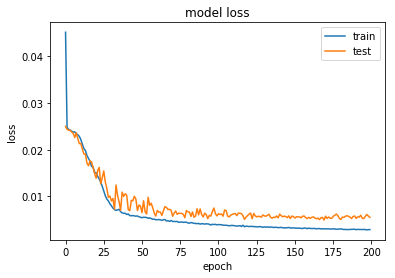

In [44]:
## use GPU or CPU
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1' (CPU)
if gpu:
    os.environ['CUDA_VISIBLE_DEVICES'] = '1'
else:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
    
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

model = create_model(GM_shape ,BR_shape, num_cnn_layer, num_rnn_layer, num_fc_layer, layer_cnn, layer_rnn, layer_fc, batch_norm, drop_rate)

if optimizer == 'adam':
    opt = Adam(lr = learning_rate, decay = lr_decay_momentum)
elif optimizer == 'sgd':
    opt = SGD(lr = learning_rate, decay = lr_decay_momentum)
model.compile(loss = loss_function, optimizer=opt)

filepath = "rnn_model_2_{epoch:03d}-{val_loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(os.path.join(working_directory, filepath), monitor='val_loss', verbose=0, save_best_only=True, mode='min', period=1)

history = model.fit([GM_train, BR_train], y_train,
              batch_size = batch_size,
              epochs = num_epochs,
              verbose=2,
              validation_data=([GM_test, BR_test], y_test),
              callbacks=[checkpoint],
              shuffle=True)

print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
def score(model_name,y_val,y_val_pred):
    print("The calculated RMSE for "+model_name+" is:%0.8f" % (sqrt(mean_squared_error(y_val, y_val_pred))))
    ARD = np.absolute(y_val_pred-y_val)/(y_val)
    MARD=np.median(np.absolute(y_val_pred-y_val)/(y_val))
    print("The median absolute relative deviation is %.4f "% (MARD))
    r2 = r2_score(y_val, y_val_pred)
    print("The R squared  is %.4f "% (r2))
    return ARD

In [ ]:
ckpt = os.listdir(working_directory)
model_file = os.path.join(working_directory, ckpt[-1])
print("Best Model File: %s" % model_file)
best_model = load_model(model_file)

y_nn_test = best_model.predict([GM_test, BR_test])
y_nn_test = y_nn_test.flatten()
model_name = 'RNN Based Seismic Response Prediction Model'
ARD = score(model_name, y_test, y_nn_test)